In [ ]:
import os
import math
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import pandas as pd
import cv2
import kornia
from matplotlib import pyplot as plt
import torchvision
import timm

In /opt/miniconda/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /opt/miniconda/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /opt/miniconda/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In /opt/miniconda/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /opt/miniconda/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mpl

torch.Size([4, 1, 163, 310])


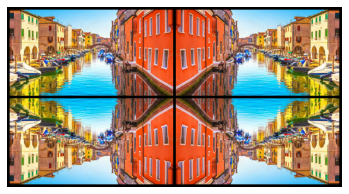

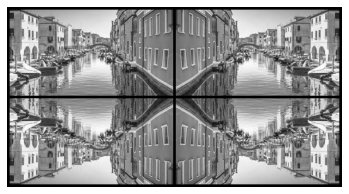

In [ ]:
def imshow(inp):
    out = torchvision.utils.make_grid(inp, nrow=2, padding=5)
    out_np = kornia.tensor_to_image(out)
    plt.imshow(out_np)
    plt.axis('off')
    plt.show()
    
def hflip(inp):
    return torch.flip(inp, [-1])

def vflip(inp):
    return torch.flip(inp, [-2])

def rot180(inp):
    return torch.flip(inp, [-2, -1])

np_bgr = cv2.imread("image.png")
x_bgr = kornia.image_to_tensor(np_bgr, keepdim=False)
xb_bgr = torch.cat([x_bgr, hflip(x_bgr), vflip(x_bgr), rot180(x_bgr)])
xb_rgb = kornia.bgr_to_rgb(xb_bgr)

xb_gray = kornia.rgb_to_grayscale(xb_rgb.float() / 255.)
print(xb_gray.shape)
imshow(xb_rgb)
imshow(xb_gray)

In [ ]:
# hsv: h - hue, s - saturation, v - brightness
# yuv: y - luma(luminance), u - blue-luma, v - red-luma
# xb_gray = kornia.rgb_to_grayscale(xb_rgb.float() / 255.)

def img_stats(img):
    with torch.no_grad():
        stats = torch.zeros(len(img),18)
        #channel = img[:,0,:,:]
        #print(channel.max(-1)[0].max(-1)[0])
        #img_rgb = img.float()/255.
        img_hsv = kornia.rgb_to_hsv(img.float())
        img_yuv = kornia.rgb_to_yuv(img.float())
        for i in range(3):
            channel_rgb = img[:,i,:,:]
            channel_hsv = img_hsv[:,i,:,:]
            channel_yuv = img_yuv[:,i,:,:]
            stats[:,2*i] = torch.mean(channel_rgb,(1,2))
            stats[:,2*i+1] = torch.std(channel_rgb,(1,2))
            stats[:,6+2*i] = torch.mean(channel_hsv,(1,2))
            stats[:,6+2*i+1] = torch.std(channel_hsv,(1,2))
            stats[:,12+2*i] = torch.mean(channel_yuv,(1,2))
            stats[:,12+2*i+1] = torch.std(channel_yuv,(1,2))
            #stats[:,18+2*i] = (channel_rgb.max(-1)[0]).max(-1)[0]
            #stats[:,18+2*i+1] = (channel_rgb.min(-1)[0]).min(-1)[0]
        return stats

#print(img_stats(xb_rgb))

In [ ]:

from torchvision import datasets
from torch.utils.data import DataLoader
from torch.utils.data import ConcatDataset
from torchvision import transforms as T
from torchvision.transforms.functional import to_grayscale
from torchvision import datasets, models, transforms
from torch.nn.functional import interpolate

transform = T.Compose([T.Resize([224,224]),T.ToTensor(),])
valset = datasets.ImageFolder('/content/val', transform=transform)
train_loader = DataLoader(valset, batch_size = 32, shuffle=True)

In [ ]:
class dropNet(nn.Module):
    def __init__(
        self,
        num_classes=10,
        kernel_size=5,
        filter1_size=5,
        filter2_size=16,
        filter3_size=8,
        fc1_size=120,
        fc2_size=84,
        input_size = 224,
    ):
        super().__init__()
        self.conv1 = nn.Conv2d(
            in_channels=3,
            out_channels=filter1_size,
            kernel_size=kernel_size,
            padding = "same",
        )
        self.conv2 = nn.Conv2d(
            in_channels=filter1_size,
            out_channels=filter2_size,
            kernel_size=kernel_size,
            padding = "same",
        )
        self.conv3 = nn.Conv2d(
            in_channels=filter2_size,
            out_channels=filter3_size,
            kernel_size=kernel_size,
            padding = "same",
        )
        self.fc1 = nn.Linear(in_features=filter3_size * int(input_size/4) ** 2, out_features=fc1_size)#nn.LazyLinear(out_features=fc1_size)#
        self.fc2 = nn.Linear(in_features=fc1_size, out_features=fc2_size)
        self.fc3 = nn.Linear(in_features=fc2_size, out_features=num_classes)
        self.dp = torch.nn.Dropout(p=0.2)
    def forward(self, x):
        out = F.relu(self.conv1(x))
        out = F.max_pool2d(out, 2)
        #print(out.shape)
        out = F.relu(self.conv2(out))
        out = self.dp(out)
        #print(out.shape)
        out = F.relu(self.conv3(out))
        out = F.max_pool2d(out, 2)
        #print(out.shape)
        out = out.view(out.size(0), -1)
        #print(out.shape)
        out = self.dp(F.relu(self.fc1(out)))
        out = F.relu(self.fc2(out))
        out = self.fc3(out)
        return out


def initialize_model(model_name, num_classes, resume_from = None, use_pretrained = False):
    # Initialize these variables which will be set in this if statement. Each of these
    #   variables is model specific.
    # The model (nn.Module) to return
    model_ft = None
    # The input image is expected to be (input_size, input_size)
    input_size = 0
    
    # By default, all parameters will be trained (useful when you're starting from scratch)
    # Within this function you can set .requires_grad = False for various parameters, if you
    # don't want to learn them

    if model_name == "resnet":
        """ Resnet18
        """
        model_ft = models.resnet18(pretrained=use_pretrained)
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs, num_classes)
        input_size = 224
        
    elif model_name == "resnet50":
        """ Resnet50
        """
        model_ft = models.resnet50(pretrained=use_pretrained)
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs, num_classes)
        input_size = 224

    elif model_name == "alexnet":
        """ Alexnet
        """
        model_ft = models.alexnet(pretrained=use_pretrained)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
        input_size = 224

    elif model_name == "vgg":
        """ VGG11_bn
        """
        model_ft = models.vgg11_bn(pretrained=use_pretrained)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
        input_size = 224

    elif model_name == "squeezenet":
        """ Squeezenet
        """
        model_ft = models.squeezenet1_0(pretrained=use_pretrained)
        model_ft.classifier[1] = nn.Conv2d(512, num_classes, kernel_size=(1,1), stride=(1,1))
        model_ft.num_classes = num_classes
        input_size = 224

    elif model_name == "densenet":
        """ Densenet
        """
        model_ft = models.densenet121(pretrained=use_pretrained)
        num_ftrs = model_ft.classifier.in_features
        model_ft.classifier = nn.Linear(num_ftrs, num_classes) 
        input_size = 224
        
    elif model_name == "vit":
        model_ft = timm.create_model('vit_small_patch16_224',pretrained = use_pretrained)
        num_ftrs = model_ft.head.in_features
        model_ft.head = nn.Linear(num_ftrs, num_classes)
        input_size = 224
        
    elif model_name == "dropnet":
        model_ft = dropNet(num_classes = num_classes)
        input_size = 224
    else:
        raise Exception("Invalid model name!")
    
    if resume_from is not None:
        print("Loading weights from %s" % resume_from)
        model_ft.load_state_dict(torch.load(resume_from))
    
    return model_ft, input_size

In [ ]:
from torch.nn.functional import interpolate

def to_input(img):
    img_gray = T.Grayscale(num_output_channels=3)(img)
    mean = torch.reshape(torch.tensor([0.485, 0.456, 0.406]),(3,1,1))
    std = torch.reshape(torch.tensor([0.229, 0.224, 0.225]),(3,1,1))
    return (img_gray-mean)/std

def train_model(model, loader, num_epochs=10):
    # Create parameter and optimizer
    optimizer = torch.optim.SGD(model.parameters(), lr=1e-2, momentum = 0.9) #momentum => take in previous gradient
    loss_module = nn.MSELoss()

    # Training loop
    for epoch in range(num_epochs):
        print("at epoch ", epoch)
        total_loss = 0
        for X, y in loader:
            yp = model(to_input(X))
            with torch.no_grad():
                yt = img_stats(X)
            loss = loss_module(yp, yt)
            total_loss += loss.item()
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        print("loss is ", total_loss)
        torch.save(model.state_dict(), "/content/dropnet_imgnet")            
    return model

def get_lost(model, loader):
    i = 0
    loss_module = nn.MSELoss()
    with torch.no_grad():
        total_loss = 0        
        for X, y in loader:
            i+=1
            if (i%100==0):
                print(i)
            yp = model(to_input(X))
            yt = img_stats(X)
            loss = loss_module(yp, yt)
            total_loss += loss.item()
        print("loss is ", total_loss)            
        return total_loss

In [ ]:
my_model, _ = initialize_model(model_name = "vit", num_classes = 18, resume_from=None, use_pretrained=True)
my_model.load_state_dict(torch.load("/content/vit_imgnet"))    
my_model.eval()
get_lost(my_model,train_loader)

#new_model = train_model(my_model,train_loader,num_epochs=5)

100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
loss is  5.674639716395177


5.674639716395177

In [ ]:
#loss start from 120-130, after 20 epoch
#dropnet: 41.183523337356746
#alexnet: 18.92139094416052
#resnet50: 10.813235650304705
#vit: 5.674639716395177